# SMYLE & DPLE Global Sea Level Pressure Skill

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import copy
import scipy.stats
from scipy import signal
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
%matplotlib inline

from SMYLEutils import calendar_utils as cal
from SMYLEutils import stat_utils as stat
from SMYLEutils import mapplot_utils as maps
from SMYLEutils import colorbar_utils as cbars
from SMYLEutils import io_utils as io

## Data I/O using Dask

### Create Dask Cluster

In [2]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='15GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=15GB',
        project='NCGD0011',
        walltime='02:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [3]:
cluster, client = get_ClusterClient()
cluster.scale(15) 

In [4]:
client

Client Scheduler: tcp://10.12.206.34:41629 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/yeager/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### Read in CAM monthly data; Convert to Seasonal averages (DJF, MAM, JJA, SON)
- Chosen field is returned as a dask array with leading dimensions of Y (initialization year), M (ensemble member), and L (lead season). For example, for November starts, L=1 corresponds to first DJF season.
- "time" which gives prediction verification time (centered time for a given season) is also dimensioned with (Y,L)

In [5]:
# This preprocessor will return a seasonal mean field
def preprocessor(ds0,nlead,field):
    """ This preprocessor is applied on an individual timeseries file basis. Edit this appropriately
    for a your analysis to speed up processing. 
    """
    ds0 = cal.time_set_mid(ds0,'time')
    d0 = ds0[field].isel(time=slice(1, nlead))
    d0 = d0.assign_coords({"lon":ds0.lon, "lat":ds0.lat})
    d0 = cal.mon_to_seas(d0)
    d0 = d0.assign_coords(L=("time", np.arange(d0.sizes["time"])+1))
    d0 = d0.swap_dims({"time": "L"})
    d0 = d0.to_dataset(name=field)
    d0 = d0.reset_coords(["time"])
    d0["time"] = d0.time.expand_dims("Y")
    return d0

In [6]:
%%time
# SMYLE-NOV SLP data
# process all 20 ensemble members, all start dates from 1970-2018:
field = 'PSL'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.cam.h0.'
filetemplate = datadir+casename+'/atm/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 11
smyle11 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
smyle11.nbytes/1e9 #GB

CPU times: user 42 s, sys: 18.8 s, total: 1min
Wall time: 1min 8s


3.468172712

In [7]:
%%time
smyle11=smyle11.load()

CPU times: user 1min 13s, sys: 6.93 s, total: 1min 20s
Wall time: 1min 19s


In [8]:
%%time
# SMYLE-FEB PSL data
# process all 20 ensemble members, all start dates from 1970-2018:
field = 'PSL'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.cam.h0.'
filetemplate = datadir+casename+'/atm/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 2
smyle02 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
smyle02.nbytes/1e9 #GB

CPU times: user 40.8 s, sys: 19 s, total: 59.8 s
Wall time: 1min 6s


3.468172712

In [9]:
%%time
smyle02=smyle02.load()

CPU times: user 1min 14s, sys: 4.71 s, total: 1min 19s
Wall time: 1min 18s


In [10]:
%%time
# SMYLE-MAY PSL data
# process all 20 ensemble members, all start dates from 1970-2018:
field = 'PSL'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.cam.h0.'
filetemplate = datadir+casename+'/atm/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 5
smyle05 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
smyle05.nbytes/1e9 #GB

CPU times: user 42.1 s, sys: 19 s, total: 1min 1s
Wall time: 1min 6s


3.468172712

In [11]:
%%time
smyle05=smyle05.load()

CPU times: user 1min 16s, sys: 4.2 s, total: 1min 20s
Wall time: 1min 19s


In [12]:
%%time
# SMYLE-AUG PSL data
# process all 20 ensemble members, all start dates from 1970-2018:
field = 'PSL'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.cam.h0.'
filetemplate = datadir+casename+'/atm/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 8
smyle08 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
smyle08.nbytes/1e9 #GB

CPU times: user 41.9 s, sys: 18.9 s, total: 1min
Wall time: 1min 6s


3.468172712

In [13]:
%%time
smyle08=smyle08.load()

CPU times: user 1min 15s, sys: 3.89 s, total: 1min 19s
Wall time: 1min 18s


In [14]:
%%time
# DPLE-NOV PSL data
# process all 40 ensemble members, all start dates from 1970-2018:
field = 'PSL'
datadir = '/glade/campaign/cesm/collections/CESM1-DPLE/atm/proc/tseries/monthly/'
casename = 'b.e11.BDP.f09_g16.????-MM.EEE'
filetype = '.cam.h0.'
filetemplate = datadir+field+'/'+casename+filetype+field+'.*.nc'
ens = 40
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 11
dple11 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
dple11.nbytes/1e9 #GB

CPU times: user 30.9 s, sys: 3.05 s, total: 33.9 s
Wall time: 45.3 s


6.79478016

In [15]:
%%time
dple11=dple11.load()

CPU times: user 2min 46s, sys: 10.3 s, total: 2min 56s
Wall time: 2min 55s


### DataArrays are manageable size now (and in memory), so release Dask cluster 

In [16]:
cluster.close()
client.close()

### Get SLP OBS

In [41]:
# ERA5  (already on CAM grid)
obs_dir = '/glade/campaign/cesm/development/espwg/verification_datasets/'
ds_era5 = xr.open_dataset(obs_dir+'mon/SLP/SLP_ERA5_oncamgrid_1950_2020.nc',decode_times=False)
era5_montime_vals = [cftime.DatetimeNoLeap(1950+year, 1+month, 15) for year in range(71) for month in range(12)]
ds_era5['time'] = era5_montime_vals
ds_era5 = ds_era5.sel(time=slice("1960","2020"))

### Compute OBS seasonal averages

In [42]:
def obs_convert_mon_to_seas(da,field):
    """ Given a monthly xarray DataArray, convert to 
    seasonal averages and introduce a separate season dimension."""
    season = xr.DataArray(['DJF','MAM','JJA','SON'],dims='season',name='season')
    da_group = cal.mon_to_seas(da).groupby('time.month')
    xrlist = []
    for i in [1,4,7,10]:
        tmp = da_group[i]
        tmp = tmp.assign_coords(year=("time", np.unique(tmp.time.dt.year.values)))
        tmp = tmp.swap_dims({"time": "year"}).to_dataset(name=field)
        tmp = tmp.reset_coords(["time"])
        tmp["time"] = tmp.time.expand_dims("season")
        xrlist.append(tmp)
    da_seas = xr.concat(xrlist,dim=season)
    return da_seas

In [44]:
era5_seas = obs_convert_mon_to_seas(ds_era5.slp,'PSL').sel(year=slice("1960","2020")).PSL
# mask over Antarctica
cam_landmask = xr.open_dataset('/glade/p/cesm/cseg/inputdata/atm/datm7/domain.lnd.fv0.9x1.25_gx1v6.090309.nc')
era5_seas = era5_seas.where((cam_landmask.yc.values >= -60) | (cam_landmask.mask.values==0))

In [45]:
## convert OBS to anomalies from 1972-2017
era5_seas = era5_seas - era5_seas.sel(year=slice(1972,2017)).mean('year')

# Anomaly Correlation Plots

In [46]:
%%time
# Compute de-drifted anomalies from 1972-2017 climatology
smyle11_anom,smyle11_clim = stat.remove_drift(smyle11,smyle11.time,1972,2017)
dple11_anom,dple11_clim = stat.remove_drift(dple11,dple11.time,1972,2017)
smyle02_anom,smyle02_clim = stat.remove_drift(smyle02,smyle02.time,1972,2017)
smyle05_anom,smyle05_clim = stat.remove_drift(smyle05,smyle05.time,1972,2017)
smyle08_anom,smyle08_clim = stat.remove_drift(smyle08,smyle08.time,1972,2017)

CPU times: user 17.2 s, sys: 15.3 s, total: 32.5 s
Wall time: 30.9 s


In [47]:
# Skill Score Functions
import xskillscore as xs

def detrend_linear(dat, dim):
    """ linear detrend dat along the axis dim """
    params = dat.polyfit(dim=dim, deg=1)
    fit = xr.polyval(dat[dim], params.polyfit_coefficients)
    dat = dat-fit
    return dat

def leadtime_corr_byseas(mod_da,mod_time,obs_da,detrend=False):
    """ 
    Computes the correlation coefficient between two xarray DataArrays, which 
    must share the same lat/lon coordinates (if any). Assumes time coordinates are roughly compatible
    between model and obs.
    
        Inputs
        mod_da: a seasonally-averaged hindcast DataArray dimensioned (Y,L,M,...)
        obs_da: an OBS DataArray dimensioned (time,...)
        mod_time: a hindcast time DataArray dimensioned (Y,L). NOTE: assumes mod_time.dt.month
            returns mid-month of 3-month seasonal average (e.g., mon=1 ==> "DJF").
    """
    ens = mod_da.mean('M')
    seasons = {1:'DJF',4:'MAM',7:'JJA',10:'SON'}
    r_list = []
    p_list = []
    for i in ens.L.values:
        ens_ts = ens.sel(L=i).rename({'Y':'time'})
        ens_time_year = mod_time.sel(L=i).dt.year.data
        ens_time_month = mod_time.sel(L=i).dt.month.data[0]
        obs_ts = obs_da.sel(season=seasons[ens_time_month]).rename({'year':'time'})
        ens_ts = ens_ts.assign_coords(time=("time",ens_time_year))
        a,b = xr.align(ens_ts,obs_ts)
        if detrend:
                a = detrend_linear(a,'time')
                b = detrend_linear(b,'time')
        r = xs.pearson_r(a,b,dim='time')
        p = xs.pearson_r_eff_p_value(a,b,dim='time')
        r_list.append(r)
        p_list.append(p)
    corr = xr.concat(r_list,ens.L)
    pval = xr.concat(p_list,ens.L)
    return xr.Dataset({'corr':corr,'pval':pval})

In [49]:
%%time
smyle11_corr = leadtime_corr_byseas(smyle11_anom.PSL,smyle11.time,era5_seas)
dple11_corr = leadtime_corr_byseas(dple11_anom.PSL,dple11.time,era5_seas)
smyle02_corr = leadtime_corr_byseas(smyle02_anom.PSL,smyle02.time,era5_seas)
smyle05_corr = leadtime_corr_byseas(smyle05_anom.PSL,smyle05.time,era5_seas)
smyle08_corr = leadtime_corr_byseas(smyle08_anom.PSL,smyle08.time,era5_seas)

CPU times: user 16.5 s, sys: 6.8 s, total: 23.3 s
Wall time: 22.9 s


CPU times: user 17.7 s, sys: 147 ms, total: 17.8 s
Wall time: 17.9 s


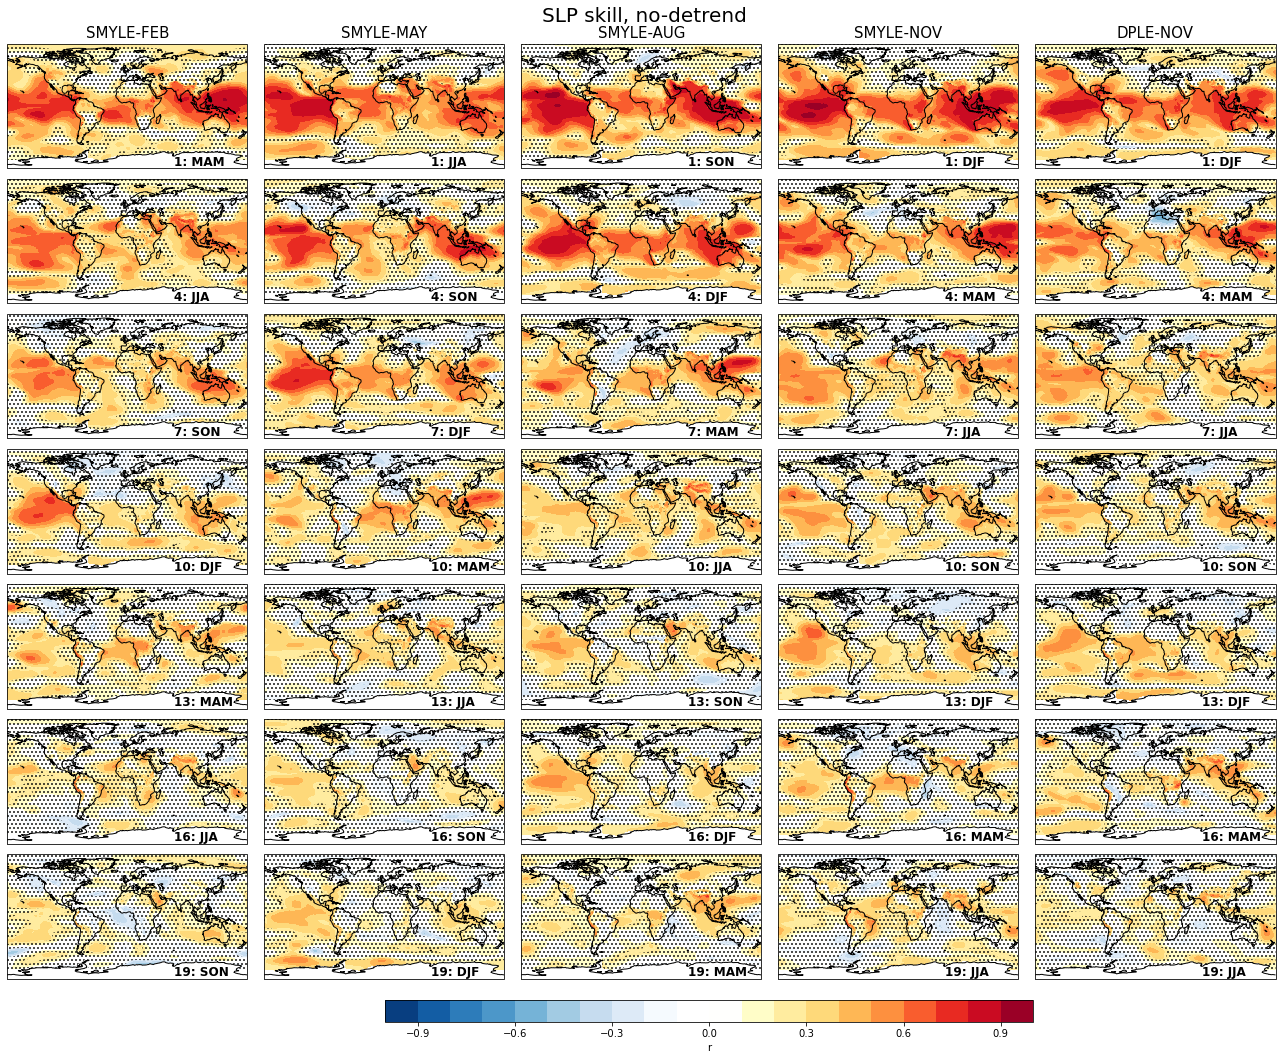

In [50]:
%%time
ci = 0.1
cmin = -1.
cmax = 1.
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(18,15))
nrows=7
ncols=5

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV','DPLE-NOV']
ltime = ['1','4','7','10','13','16','19']
lstr = ''
rstr = ''
fsize=12
fweight='bold'

for i in range(nrows):
    if i>0:
        colstr=['','','','','']
    leadstr = ltime[i]+': '
    ax1,cntr1 = maps.map_contourf_global_subplot(fig, smyle02_corr.corr.isel(L=i), smyle02_corr.lon, smyle02_corr.lat,
                                       ci,cmin,cmax,colstr[0],lstr,rstr,nrows,ncols,i*5+1,proj)
    ax1.contourf(smyle02_corr.lon, smyle02_corr.lat,smyle02_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle02_corr.isel(L=i).season.values)
    ax1.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax2,cntr2 = maps.map_contourf_global_subplot(fig, smyle05_corr.corr.isel(L=i), smyle05_corr.lon, smyle05_corr.lat,
                                       ci,cmin,cmax,colstr[1],lstr,rstr,nrows,ncols,i*5+2,proj)
    ax2.contourf(smyle05_corr.lon, smyle05_corr.lat,smyle05_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle05_corr.isel(L=i).season.values)
    ax2.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax3,cntr3 = maps.map_contourf_global_subplot(fig, smyle08_corr.corr.isel(L=i), smyle08_corr.lon, smyle08_corr.lat,
                                       ci,cmin,cmax,colstr[2],lstr,rstr,nrows,ncols,i*5+3,proj)
    ax3.contourf(smyle08_corr.lon, smyle08_corr.lat,smyle08_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle08_corr.isel(L=i).season.values)
    ax3.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax4,cntr4 = maps.map_contourf_global_subplot(fig, smyle11_corr.corr.isel(L=i), smyle11_corr.lon, smyle11_corr.lat,
                                       ci,cmin,cmax,colstr[3],lstr,rstr,nrows,ncols,i*5+4,proj)
    ax4.contourf(smyle11_corr.lon, smyle11_corr.lat,smyle11_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle11_corr.isel(L=i).season.values)
    ax4.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax5,cntr5 = maps.map_contourf_global_subplot(fig, dple11_corr.corr.isel(L=i), dple11_corr.lon, dple11_corr.lat,
                                       ci,cmin,cmax,colstr[4],lstr,rstr,nrows,ncols,i*5+5,proj)
    ax5.contourf(dple11_corr.lon, dple11_corr.lat,dple11_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(dple11_corr.isel(L=i).season.values)
    ax5.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)


fig.suptitle('SLP skill, no-detrend',fontsize=20)
fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label='r', orientation='horizontal')

### Test Significance Hatching using correlation p-values

CPU times: user 590 ms, sys: 4.75 ms, total: 594 ms
Wall time: 599 ms


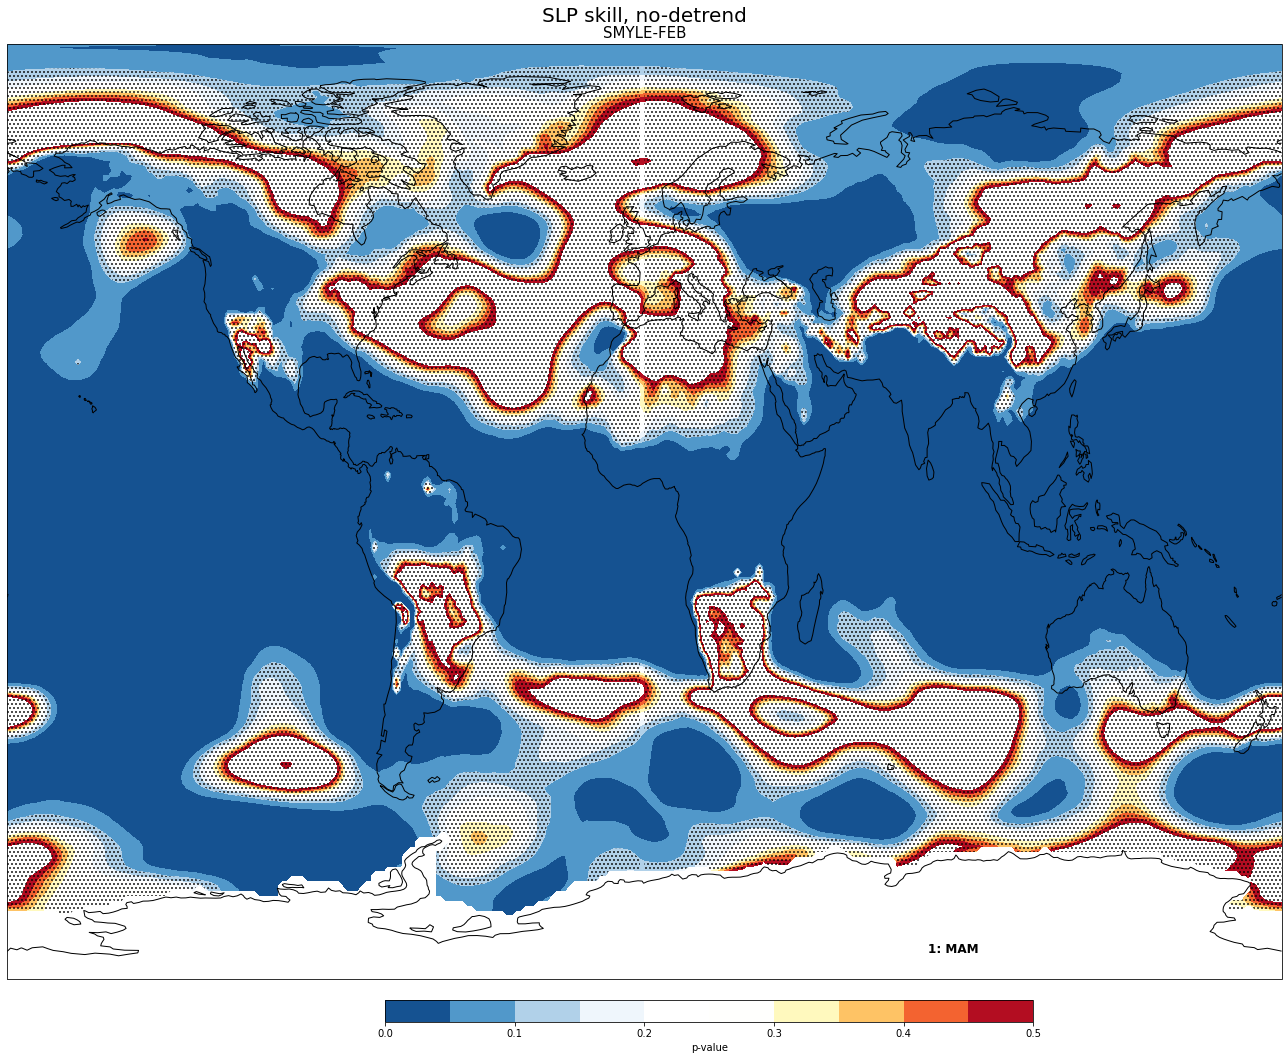

In [52]:
%%time
ci = 0.05
cmin = 0.0
cmax = 0.5
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(18,15))
nrows=1
ncols=1

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV','DPLE-NOV']
lstr = ''
rstr = ''
fsize=12
fweight='bold'

for i in range(nrows):
    if i>0:
        colstr=['','','','','']
    leadstr = str(i+1)+': '
    ax1,cntr1 = maps.map_contourf_global_subplot(fig, smyle02_corr.pval.isel(L=i), smyle02_corr.lon, smyle02_corr.lat,
                                       ci,cmin,cmax,colstr[0],lstr,rstr,nrows,ncols,i*5+1,proj)
    ax1.contourf(smyle02_corr.lon, smyle02_corr.lat,smyle02_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...','...'], alpha=0.)
    ldstr = str(i+1) + ': ' + str(smyle02_corr.isel(L=i).season.values)
    ax1.text(80.,-85,ldstr,fontsize=fsize,fontweight=fweight)



fig.suptitle('SLP skill, no-detrend',fontsize=20)
fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label='p-value', orientation='horizontal')

### Use Linear Detrending

In [53]:
%%time
smyle11_corr = leadtime_corr_byseas(smyle11_anom.PSL,smyle11.time,era5_seas,detrend=True)
dple11_corr = leadtime_corr_byseas(dple11_anom.PSL,dple11.time,era5_seas,detrend=True)
smyle02_corr = leadtime_corr_byseas(smyle02_anom.PSL,smyle02.time,era5_seas,detrend=True)
smyle05_corr = leadtime_corr_byseas(smyle05_anom.PSL,smyle05.time,era5_seas,detrend=True)
smyle08_corr = leadtime_corr_byseas(smyle08_anom.PSL,smyle08.time,era5_seas,detrend=True)

CPU times: user 38.8 s, sys: 8.54 s, total: 47.3 s
Wall time: 51.7 s


CPU times: user 20.8 s, sys: 168 ms, total: 20.9 s
Wall time: 20.9 s


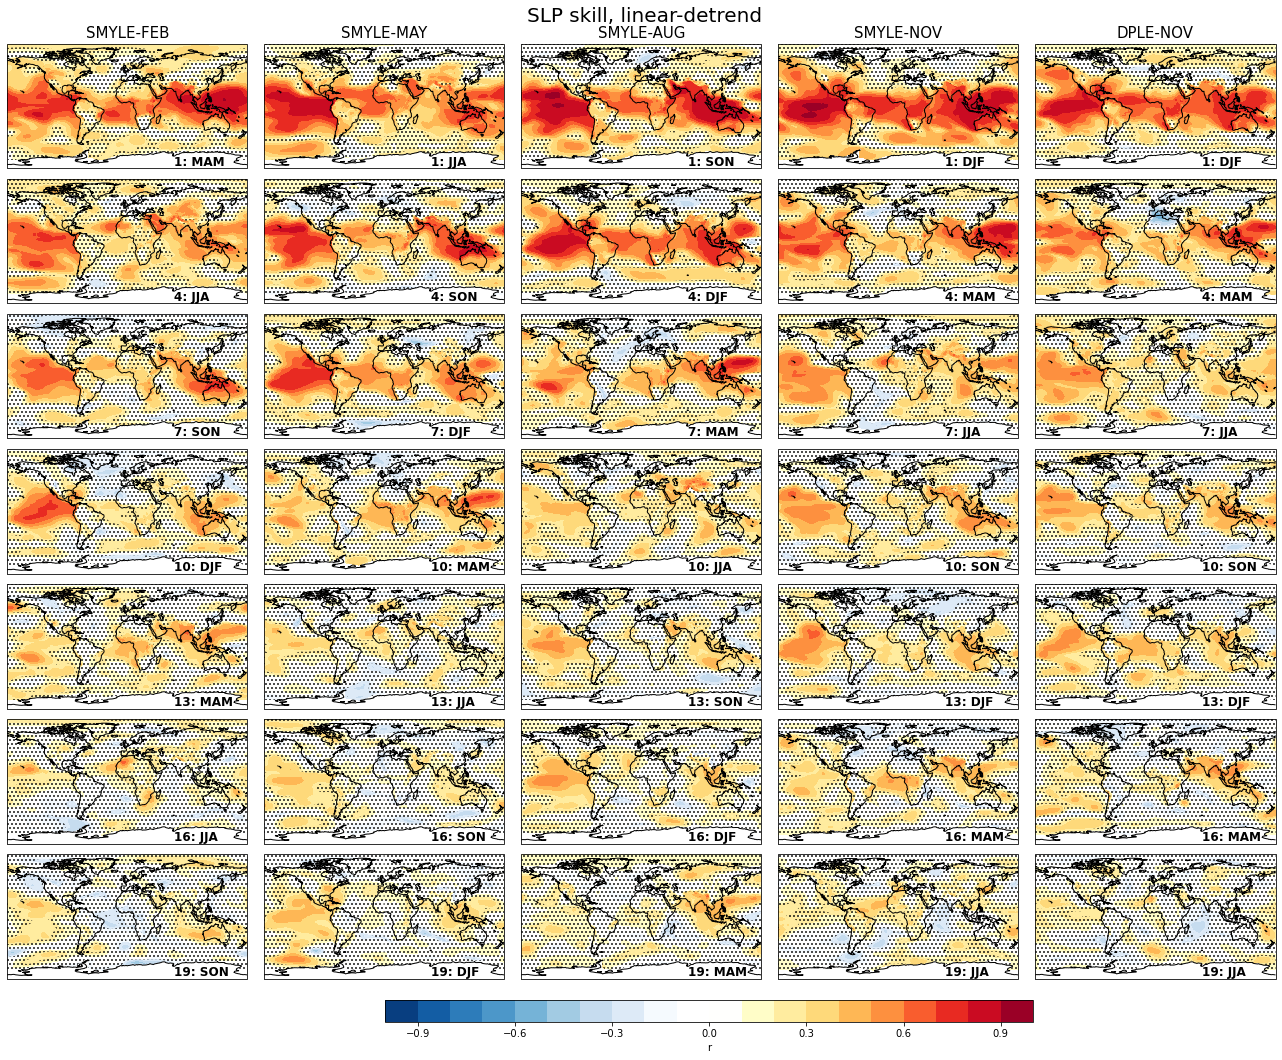

In [54]:
%%time
ci = 0.1
cmin = -1.
cmax = 1.
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(18,15))
nrows=7
ncols=5

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV','DPLE-NOV']
ltime = ['1','4','7','10','13','16','19']
lstr = ''
rstr = ''
fsize=12
fweight='bold'

for i in range(nrows):
    if i>0:
        colstr=['','','','','']
    leadstr = ltime[i]+': '
    ax1,cntr1 = maps.map_contourf_global_subplot(fig, smyle02_corr.corr.isel(L=i), smyle02_corr.lon, smyle02_corr.lat,
                                       ci,cmin,cmax,colstr[0],lstr,rstr,nrows,ncols,i*5+1,proj)
    ax1.contourf(smyle02_corr.lon, smyle02_corr.lat,smyle02_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle02_corr.isel(L=i).season.values)
    ax1.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax2,cntr2 = maps.map_contourf_global_subplot(fig, smyle05_corr.corr.isel(L=i), smyle05_corr.lon, smyle05_corr.lat,
                                       ci,cmin,cmax,colstr[1],lstr,rstr,nrows,ncols,i*5+2,proj)
    ax2.contourf(smyle05_corr.lon, smyle05_corr.lat,smyle05_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle05_corr.isel(L=i).season.values)
    ax2.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax3,cntr3 = maps.map_contourf_global_subplot(fig, smyle08_corr.corr.isel(L=i), smyle08_corr.lon, smyle08_corr.lat,
                                       ci,cmin,cmax,colstr[2],lstr,rstr,nrows,ncols,i*5+3,proj)
    ax3.contourf(smyle08_corr.lon, smyle08_corr.lat,smyle08_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle08_corr.isel(L=i).season.values)
    ax3.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax4,cntr4 = maps.map_contourf_global_subplot(fig, smyle11_corr.corr.isel(L=i), smyle11_corr.lon, smyle11_corr.lat,
                                       ci,cmin,cmax,colstr[3],lstr,rstr,nrows,ncols,i*5+4,proj)
    ax4.contourf(smyle11_corr.lon, smyle11_corr.lat,smyle11_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle11_corr.isel(L=i).season.values)
    ax4.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax5,cntr5 = maps.map_contourf_global_subplot(fig, dple11_corr.corr.isel(L=i), dple11_corr.lon, dple11_corr.lat,
                                       ci,cmin,cmax,colstr[4],lstr,rstr,nrows,ncols,i*5+5,proj)
    ax5.contourf(dple11_corr.lon, dple11_corr.lat,dple11_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(dple11_corr.isel(L=i).season.values)
    ax5.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)


fig.suptitle('SLP skill, linear-detrend',fontsize=20)
fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label='r', orientation='horizontal')
plt.savefig('Fig_S1.png')